## A NMC/Gr parameterisation example using NlOpt & PyBOP

This notebook introduces a synthetic, dynamic, re-parameterisation of the single-particle model with corrupted observations. To start, we import the PyBOP package for parameterisation and the PyBaMM package to generate the initial synethic data,

In [17]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [18]:
import pybop
import numpy as np

### Generate Synthetic Data

To demonstrate parameter estimation, we first need synthetic data. This data will be generated using the PyBOP forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set and then instantiate the single-particle model (SPM):

In [19]:
model = pybop.lithium_ion.SPM()
params = model.default_parameter_values

We can now modify individual parameters with the bespoke values and run the simulation.

In [20]:
params.update(
    {
        "Negative electrode active material volume fraction": 0.48,
        "Positive electrode active material volume fraction": 0.54,
    }
)

### Simulating Forward Model

First, we define the PyBOP experiment (wrapper class for the PyBaMM experiment), next we can then simulate the model using the `predict` method.

In [21]:
experiment = pybop.Experiment(
    [
        (
            "Discharge at 1C for 15 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
            "Charge at 1C for 15 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
        ),
    ]
    * 2
)
sol = model.predict(experiment=experiment, parameter_set=params)

Now, let's corrupt the synthetic data with 3mV of gaussian noise centered around zero,

In [22]:
corrupt_V = sol["Voltage [V]"].data
corrupt_V += np.random.normal(0, 0.003, len(corrupt_V))

## Identify the Parameters

Now, to blind fit the synthetic parameters we need to define the observation variables. For the observed voltage variable, we used the newly corrupted voltage array,

In [23]:
dataset = pybop.Dataset(
    {
        "Time [s]": sol["Time [s]"].data,
        "Current function [A]": sol["Current [A]"].data,
        "Voltage [V]": corrupt_V,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds. The initial parameters values used in the estimiation will be randomly drawn from the prior distribution.

In [24]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.5, 0.02),
        bounds=[0.48, 0.625],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.6, 0.02),
        bounds=[0.525, 0.75],
    ),
]

We can now define the fitting signal, a problem (which combines the model with the dataset) and construct a cost function.

In [25]:
signal = "Voltage [V]"
problem = pybop.FittingProblem(model, parameters, dataset, signal=signal)
cost = pybop.RootMeanSquaredError(problem)

Let's construct PyBOP's optimisation class. This class provides the methods needed to fit the forward model. For this example, we use a root-mean square cost function with the BOBYQA algorithm implemented in NLOpt.

In [26]:
optim = pybop.Optimisation(cost=cost, optimiser=pybop.NLoptOptimize)
optim.set_max_iterations(100)

Finally, we run the estimation algorithm.

In [27]:
x, final_cost = optim.run()

Let's view the identified parameters:

In [28]:
x

array([0.5263475 , 0.53595478])

## Plotting and Visualization

We can quickly plot the system's response using the estimated parameters compared to the target:

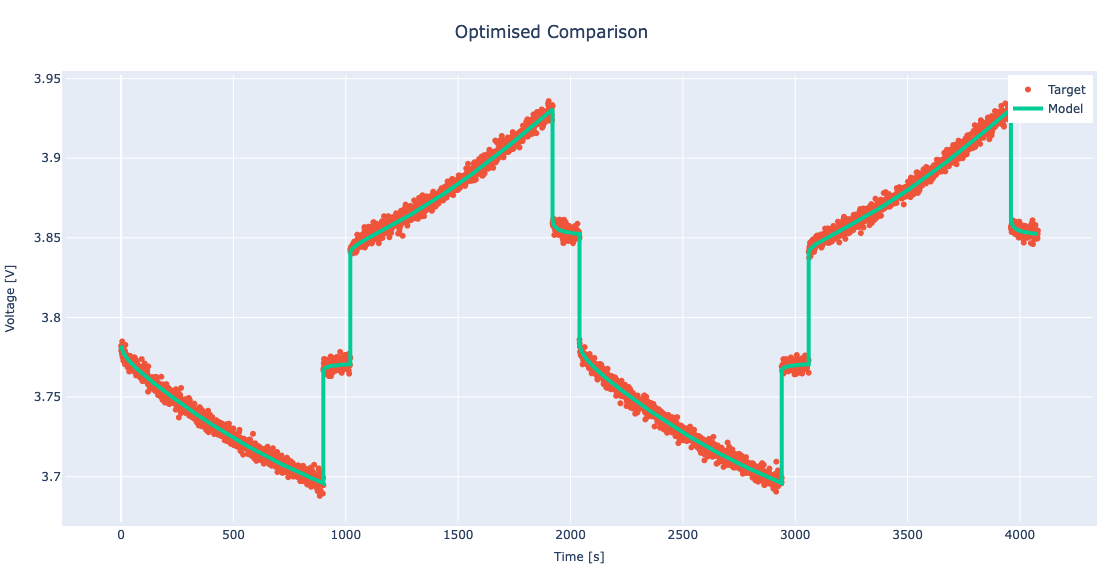

In [29]:
pybop.quick_plot(x, cost, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimization process, we can plot the convergence of the cost function and the trajectories of the parameters:

In [ ]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Cost Landscape

Finally, we can visualize the cost landscape and the path taken by the optimizer:

In [ ]:
# Plot the cost landscape
pybop.plot_cost2d(cost, steps=15)
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.6, 0.9], [0.5, 0.8]])
pybop.plot_cost2d(cost, optim=optim, bounds=bounds, steps=15);